In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

### ResNet网络结构

In [3]:
# 定义resnet18与resnet34所需残差单元
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, downsample=None, stride=1):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                             kernel_size=3, stride=stride, padding=1)
        # 进行BN处理
        self.bn1 = nn.BatchNorm2d(out_channel, momentum=0.9, eps=1e-5)
        # relu函数
        self.relu = nn.ReLU(inplace=True)
        # 第二层保持图片样本的通道数不变
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        # 对第二层进行BN处理
        self.bn2 = nn.BatchNorm2d(out_channel, momentum=0.9, eps=1e-5)
    
    # 对图片样本数据x进行残差映射
    def forward(self, x):
        identity = x
        # 进行残差连接
        Fx = self.conv1(x)
        Fx = self.bn1(Fx)
        Fx = self.relu(Fx)

        Fx = self.conv2(Fx)
        Fx = self.bn2(Fx)

        if(self.downsample!=None):
            identity = self.downsample(x)
        # 残差与原来的值相加
        Fx += identity
        Fx = self.relu(Fx)
        return Fx

In [4]:
class resnet(nn.Module):
    # block为残差单元，layers存储每层所需模块数量，in_channel为原始数据通过第一层后的通道数
    # num_classes为分类的种类数
    def __init__(self, block, layers, in_channel=1, num_classes=2):
        super().__init__()
        self.in_channel = in_channel
        self.conv = nn.Conv2d(in_channels=1, out_channels=self.in_channel, kernel_size=3,
                              stride=1, padding=1, bias=False)
        # bn处理
        self.bn = nn.BatchNorm2d(self.in_channel, momentum=0.9, eps=1e-5)
        # relu函数
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, in_channel, layers[0])
        self.layer2 = self._make_layer(block, 2*in_channel, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 4*in_channel, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 8*in_channel, layers[3], stride=2)
        # 自适应avg-pooling处理
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # fc
        self.fc = nn.Linear(self.in_channel, num_classes)

        # 初始化各层参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channel, block_num, stride=1):
        expansion = block.expansion
        downsample = None
        if(stride !=1 or self.in_channel != out_channel*expansion):
            # 下采样函数
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=out_channel*expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel*expansion)
            )
        layers = []
        # 一开始使用步长stride=2的模块使得数据大小减半，通道数加倍，同时设置好downsample函数
        layers.append(block(self.in_channel, out_channel, downsample, stride))
        # 到同一层的相同block的输入通道数变为out_channel*expansion
        self.in_channel = out_channel*expansion
        for _ in range(1, block_num):
            # 之后上一层的输出作为下一层的输入，每一层保持输入通道数以及输出通道数不变
            layers.append(block(self.in_channel, out_channel))
        return nn.Sequential(*layers)
    
    # 进行训练
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

### 读取数据

In [21]:
df = pd.read_csv('../data/processed.csv')
df_test = pd.read_csv('../data/processed_test.csv')
df_submit = pd.read_csv('../data/submission.csv')

# 归一化
for i in df.columns:
    if(i == 'bad_good'):
        continue
    df[i] = df[i].astype(float)
    df_test[i] = df_test[i].astype(float)
    df[i] = (df[i]-df[i].min())/(df[i].max()-df[i].min())
    df_test[i] = (df_test[i]-df_test[i].min())/(df_test[i].max()-df_test[i].min())


y_train_corr = []
for col in df.columns:
    if col != 'bad_good':
        y_train_corr.append((col, abs(df['bad_good'].corr(df[col]))))
y_train_corr.sort(key=lambda item: item[1])
cols = [item[0] for item in y_train_corr]
corrs = [item[1] for item in y_train_corr]

data = df[cols[-256: ] + ['bad_good']].copy()
test_data = df_test[cols[-256: ]].copy()


### 欠采样

In [36]:
df_tran1=data[data['bad_good']==0]
df_tran2=data[data['bad_good']==1]
num = 3200
train_data=pd.concat([df_tran1.sample(n=num*3), df_tran2.sample(num)])
val_data = data.sample(n=64000)
X_train, y_train = train_data.iloc[:, :256], train_data['bad_good']
X_val, y_val = val_data.iloc[:, :256], val_data['bad_good']
X_test = test_data

In [8]:
# 非欠采样过程
# train_data, val_data = train_test_split(data, test_size=0.01)
# X_train, y_train = train_data.iloc[:16000, :256], train_data['bad_good']
# X_val, y_val = val_data.iloc[:1600, :256], val_data['bad_good']
# X_test = test_data

In [9]:
model = resnet(BasicBlock, [1, 1, 1, 1], 1)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 将训练移动到指定设备上
model.to(DEVICE)
# 初始SGD优化器参数
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 训练数据处理
X_train_tensor = torch.tensor(X_train.to_numpy())
y_train_tensor = torch.tensor(y_train.to_numpy())
X_train_tensor = X_train_tensor.unsqueeze(2)
X_train_tensor = X_train_tensor.reshape(int(len(X_train_tensor)/32), 32, 1, 16, 16)
# X_train_tensor = X_train_tensor.reshape(int(len(X_train_tensor)/32), 32, 1, 256)
X_train_tensor = X_train_tensor.type(torch.FloatTensor)

X_val_tensor = torch.tensor(X_val.to_numpy())
y_val_tensor = torch.tensor(y_val.to_numpy())
X_val_tensor = X_val_tensor.unsqueeze(2)
X_val_tensor = X_val_tensor.reshape(int(len(X_val_tensor)/32), 32, 1, 16, 16)
# X_val_tensor = X_val_tensor.reshape(int(len(X_val_tensor)/32), 32, 1, 256)
X_val_tensor = X_val_tensor.type(torch.FloatTensor)

In [11]:
n = len(X_train_tensor)
m = len(X_val_tensor)
X_train_tensor, y_train_tensor = X_train_tensor.to(DEVICE), y_train_tensor.to(DEVICE)
X_val_tensor, y_val_tensor = X_val_tensor.to(DEVICE), y_val_tensor.to(DEVICE)

loss_list = []
for x in range(20):
    train_num = 0
    val_num = 0
    sum_loss = 0

    for i in range(n):
        output = model(X_train_tensor[i])
        # 计算交叉熵
        loss = criterion(output, y_train_tensor[32*i : 32*(i+1)])
        sum_loss += loss
        _, pred = torch.max(output.data, 1)
        train_num += torch.sum(pred == y_train_tensor[32*i : 32*(i+1)])
        # 将梯度归零
        optimizer.zero_grad()
        # 反向传播计算得到每个参数的梯度
        loss.backward()
        # 通过梯度下降执行一步参数更新
        optimizer.step()
    for i in range(m):
        output = model(X_val_tensor[i])
        _, pred = torch.max(output.data, 1)
        val_num += torch.sum(pred == y_val_tensor[32*i : 32*(i+1)])
    loss_list.append(float(sum_loss/n))
    print("EPOCH {}: train_acc: {} val_acc: {}".format(x, train_num/(num*4), val_num/64000))

EPOCH 0: train_acc: 0.9110937118530273 val_acc: 0.016687501221895218
EPOCH 1: train_acc: 0.8743749856948853 val_acc: 0.016703125089406967
EPOCH 2: train_acc: 0.8585156202316284 val_acc: 0.01667187549173832
EPOCH 3: train_acc: 0.8549999594688416 val_acc: 0.016953125596046448
EPOCH 4: train_acc: 0.891406238079071 val_acc: 0.2344375103712082
EPOCH 5: train_acc: 0.9544531106948853 val_acc: 0.1731875091791153
EPOCH 6: train_acc: 0.9669530987739563 val_acc: 0.9784375429153442
EPOCH 7: train_acc: 0.9996874928474426 val_acc: 0.983343780040741
EPOCH 8: train_acc: 0.9999218583106995 val_acc: 0.983343780040741
EPOCH 9: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 10: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 11: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 12: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 13: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 14: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 15: train_acc: 1.0 val_acc: 0.983343780040741
EPOCH 16: train_acc: 1.0 val_a

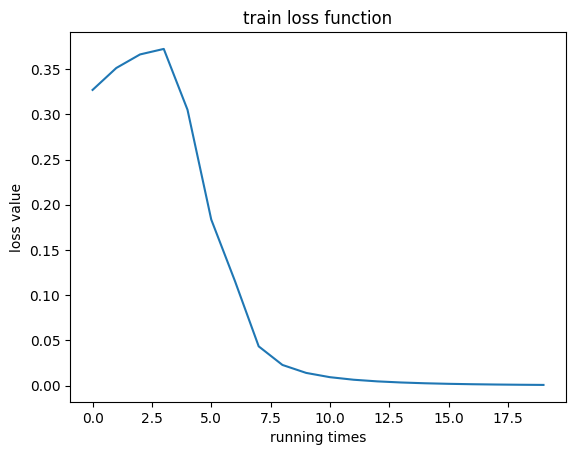

In [12]:
plt.title("train loss function")
plt.xlabel("running times")
plt.ylabel("loss value")
plt.plot(list(range(len(loss_list))), loss_list)
plt.savefig('train_loss.png')

In [13]:
X_test_tensor = torch.tensor(X_test.to_numpy())
X_test_tensor = X_test_tensor.unsqueeze(2)
X_test_tensor = X_test_tensor.reshape(len(X_test_tensor), 1, 1, 16, 16)
# X_test_tensor = X_test_tensor.reshape(len(X_test_tensor), 1, 1, 256)
X_test_tensor = X_test_tensor.type(torch.FloatTensor)

In [14]:
pred_list = []
X_test_tensor = X_test_tensor.to(DEVICE)
for i in range(len(X_test_tensor)):
    output = model(X_test_tensor[i])
    _, pred = torch.max(output.data, 1)
    if(pred == 0):
        pred_list.append(0)
    else:
        pred_list.append(1)
    if(i % 1000 == 0):
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [15]:
df_pred = pd.DataFrame({'bad_good': pred_list})
df_pred.insert(0, 'CUST_ID', df_submit['CUST_ID'])

In [16]:
df_pred['bad_good'].value_counts()

bad_good
0    180698
1      9068
Name: count, dtype: int64

In [17]:
df_pred.to_csv('result_MLP.csv', mode='w', index=False)